# Exploratory Data Analysis of Last.fm's Mood Tags

The Last.fm Tags dataset is a complementary dataset included as part of the Million Song Dataset. More information can be found [here](https://labrosa.ee.columbia.edu/millionsong/lastfm).

The dataset is available in several different forms including individual json files for each track as well as an sqlite db. Iterating over the json files is cumbersome, so we make use of the sqlite db here.

The goal of this workbook is to explore the tags available in the Last.fm dataset with a special focus on the moods targeted in our project.

In [21]:
import matplotlib.pyplot as plt
from importlib import reload
from pprint import pprint
import pandas as pd

%pprint
%matplotlib inline

Pretty printing has been turned ON


# Getting Started

### Connecting to the DB

In [2]:
from lastfm_labels import LASTFM_TAGS_DB
import sqlite3

conn = sqlite3.connect(LASTFM_TAGS_DB)

### Example Last.fm Tags Queries

These examples are taken from the very helpful [MSD provided example code](https://labrosa.ee.columbia.edu/millionsong/sites/default/files/lastfm/demo_tags_db.py) demonstrating how to work with the last.fm sqlite db.

In [3]:
from lastfm_labels import sanitize

In [4]:
print('************** DEMO 4 **************')
tag = 'Acid Smurfs'
print('We get all tracks for the tag: {0}'.format(tag))
sql = "SELECT tids.tid FROM tid_tag, tids, tags WHERE tids.ROWID=tid_tag.tid AND tid_tag.tag=tags.ROWID AND tags.tag='%s'" % sanitize(tag)
res = conn.execute(sql)
data = res.fetchall()

pprint(data)

************** DEMO 4 **************
We get all tracks for the tag: Acid Smurfs
[('TRDATLJ128F92FC75F',),
 ('TRVTZIF128F42725C1',),
 ('TREPQOO128F9328886',),
 ('TROXKKP128F427886F',)]


In [5]:
print('************** DEMO 5 **************')
print("We get all tags and the number of tracks they're applied to")
sql = "SELECT tags.tag, COUNT(tid_tag.tid) FROM tid_tag, tags WHERE tid_tag.tag=tags.ROWID GROUP BY tags.tag"

### WARNING - this one takes a minute... uncomment these lines to execute
#res = conn.execute(sql)
#data = res.fetchall()
#data = sorted(data, key=lambda x: x[1], reverse=True)
#print('after sorting...')
#for k in range(10):
#    print(data[k])
#print('...')

************** DEMO 5 **************
We get all tags and the number of tracks they're applied to


### Last.fm DB Schema Exploration

In order to use the provided db effectively, we need to know its schema. Here we use sql commands to expose its table structure (credit: https://www.tomordonez.com/get-schema-sqlite-python.html).

It turns out that the schema is incredibly simple.


In [45]:
cur = conn.cursor()

tables = list()
for row in cur.execute("SELECT name FROM sqlite_master WHERE type='table';").fetchall():
    tables.append(row[0])

print('Tables: {0}\n'.format(tables))

for table in tables:
    
    cols = list()
    for row in cur.execute("pragma table_info('{0}')".format(table)).fetchall():
        cols.append(row[1])

    row_count = cur.execute("SELECT Count(*) FROM {0}".format(table)).fetchall()[0][0]
        
    print('Table "{0}"'.format(table))
    print('\tcolumns: {0}'.format(cols))
    print('\trows: {0}'.format(row_count))
    
    #print(cur.execute("SELECT * FROM {0} LIMIT 5".format(table)).fetchall())
    
cur.close()

Tables: ['tags', 'tids', 'tid_tag']

Table "tags"
	columns: ['tag']
	rows: 522366
[('classic rock',), ('Progressive rock',), ('blues',), ('memphis slim',), ('pop',)]
Table "tids"
	columns: ['tid']
	rows: 505216
[('TRCCCYE12903CFF0E9',), ('TRCCCFH12903CEBC70',), ('TRCCCJT128F429FFF6',), ('TRCCCBJ128F4286E6F',), ('TRCCJTI128EF35394A',)]
Table "tid_tag"
	columns: ['tid', 'tag', 'val']
	rows: 8598630
[(1, 1, 100.0), (1, 2, 100.0), (2, 3, 100.0), (2, 4, 100.0), (3, 5, 100.0)]


And here is a quick peek at the beginning five rows of each table.

In [47]:
for table in tables:
    
    df = pd.read_sql_query("SELECT * FROM {0} LIMIT 5".format(table), conn)
    print(df)

                tag
0      classic rock
1  Progressive rock
2             blues
3      memphis slim
4               pop
                  tid
0  TRCCCYE12903CFF0E9
1  TRCCCFH12903CEBC70
2  TRCCCJT128F429FFF6
3  TRCCCBJ128F4286E6F
4  TRCCJTI128EF35394A
   tid  tag    val
0    1    1  100.0
1    1    2  100.0
2    2    3  100.0
3    2    4  100.0
4    3    5  100.0


### Matching a Song to its Labels

With the mapping data from MusixMatch and the sqlite db from last.fm, we can tie songs to their labels.

In [49]:
example_song = {
    'msd_id': 'TRLIEDO12903CA41B4',
    'msd_artist': '10 CC',
    'msd_title': 'The Things We Do For Love',
    'mxm_id': '2258063',
    'mxm_artist': '10cc',
    'mxm_title': 'The Things We Do for Love'
}
sql = "SELECT tids.tid, tags.tag, tid_tag.val FROM tid_tag, tids, tags WHERE tids.ROWID=tid_tag.tid AND tid_tag.tag=tags.ROWID AND tids.tid='{0}'".format(sanitize(example_song['msd_id']))
res = conn.execute(sql)
data = res.fetchall()
pprint(data)


[('TRLIEDO12903CA41B4', 'classic rock', 53.0),
 ('TRLIEDO12903CA41B4', 'pop', 28.0),
 ('TRLIEDO12903CA41B4', '70s', 100.0),
 ('TRLIEDO12903CA41B4', 'rock', 38.0),
 ('TRLIEDO12903CA41B4', 'favorites', 3.0),
 ('TRLIEDO12903CA41B4', 'upbeat', 2.0),
 ('TRLIEDO12903CA41B4', 'loved', 2.0),
 ('TRLIEDO12903CA41B4', 'Awesome', 2.0),
 ('TRLIEDO12903CA41B4', 'british', 4.0),
 ('TRLIEDO12903CA41B4', 'Love', 4.0),
 ('TRLIEDO12903CA41B4', 'first person songs', 1.0),
 ('TRLIEDO12903CA41B4', 'male vocalists', 5.0),
 ('TRLIEDO12903CA41B4', 'adult contemporary', 2.0),
 ('TRLIEDO12903CA41B4', 'soft rock', 33.0),
 ('TRLIEDO12903CA41B4', 'pop rock', 3.0),
 ('TRLIEDO12903CA41B4', "70's", 2.0),
 ('TRLIEDO12903CA41B4', '1970s', 2.0),
 ('TRLIEDO12903CA41B4', 'oldies', 9.0),
 ('TRLIEDO12903CA41B4', 'love songs', 6.0),
 ('TRLIEDO12903CA41B4', 'close harmony', 2.0),
 ('TRLIEDO12903CA41B4', 'acclaimed music top 3000', 2.0),
 ('TRLIEDO12903CA41B4', 'golden oldies', 3.0),
 ('TRLIEDO12903CA41B4', 'easy now', 1.0),
 (

# Tag EDA

Now that we know the schema and how to connect to and query the db, we can investigate its contents.

### Number of Tags

In [7]:
from lastfm_labels import query

data = query(conn, "SELECT tag FROM tags")
print('Number of Tags:', len(data))

data = query(conn, "SELECT tag FROM tags LIMIT 10")
print('\nExample Tags:', ([x[0] for x in data]))


Number of Tags: 522366

Example Tags: ['classic rock', 'Progressive rock', 'blues', 'memphis slim', 'pop', '70s', 'Middle of the road', 'Bonjour ca va', 'Tony Levin', 'instrumental']


### Tag Count Histogram

In [8]:
df = pd.read_sql_query("SELECT tags.tag, COUNT(tid_tag.tid) as count FROM tid_tag, tags WHERE tid_tag.tag=tags.ROWID GROUP BY tags.tag ORDER BY count desc", conn)

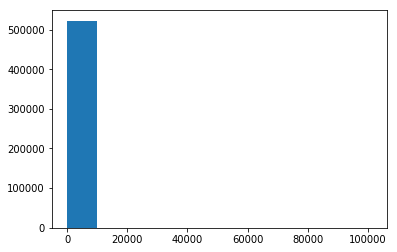

In [26]:
histodata = df
_ = plt.hist(histodata['count'])

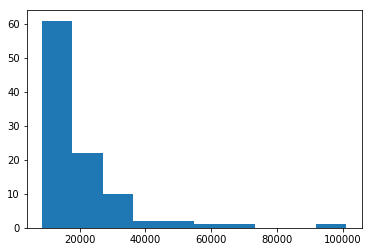

In [27]:
histodata = df.head(100)
_ = plt.hist(histodata['count'])

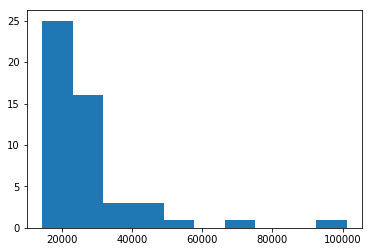

In [28]:
histodata = df.head(50)
_ = plt.hist(histodata['count'])

# Defining the Moods

### Mood Categories

The moods and categories we use are based on the mapping found in the paper ["Lyric Text Mining in Music Mood Classification"](http://www.ismir2009.ismir.net/proceedings/PS3-4.pdf).

H. Xiao, J. S. Downie, and A. F. Ehmann, “Lyric TextMining in Music Mood Classiﬁcation,” American Mu-sic, vol. 183, no. 5040, pp. 411–416, 2009



In [29]:
from lastfm_labels import MOOD_CATEGORIES
print('Number of Mood Categories = {0}\n'.format(len(MOOD_CATEGORIES)))
print('Categories:\n')
pprint(MOOD_CATEGORIES)

Number of Mood Categories = 18

Categories:

{'aggression': ['aggression', 'aggressive'],
 'anger': ['anger', 'angry', 'choleric', 'fury', 'outraged', 'rage'],
 'angst': ['angst', 'anxiety', 'anxious', 'jumpy', 'nervous', 'angsty'],
 'brooding': ['brooding', 'contemplative', 'meditative', 'reflective'],
 'calm': ['calm', 'comfort', 'quiet', 'serene', 'mellow', 'chill out'],
 'cheerful': ['cheerful', 'cheer up', 'festive', 'jolly', 'jovial', 'merry'],
 'confident': ['confident', 'encouraging', 'encouragement', 'optimism'],
 'depressed': ['depressed', 'blue', 'dark', 'depressive', 'dreary'],
 'desire': ['desire', 'hope', 'hopeful', 'mood: hopeful'],
 'dreamy': ['dreamy'],
 'earnest': ['earnest', 'heartfelt'],
 'excitement': ['excitement', 'exciting', 'exhilarating', 'thrill', 'ardor'],
 'grief': ['grief', 'heartbreak', 'mournful', 'sorrow', 'sorry'],
 'happy': ['happy', 'happiness', 'happy songs', 'happy music'],
 'pessimism': ['pessimism', 'cynical', 'pessimistic', 'weltschmerz'],
 'rom

### Category Breakdown For '1' Artists

In [50]:
import index_lyrics
#reload(index_lyrics)

In [44]:
from scrape_lyrics import make_lyric_file_name
from etl_lyrics import read_file_contents
import os

data_path = 'data/lyrics/json'
for lyric_file in os.listdir(data_path):
    if lyric_file.startswith('1'):
        lyric_file = os.path.join(data_path, lyric_file)
        print(lyric_file)
        lyrics_json = read_file_contents(lyric_file, read_json=True)
        pprint(lyric_json)
        break

data/lyrics/json\10000_Maniacs___Across_The_Fields.json
{'artist': '10,000 Maniacs',
 'songs': [{'album': 'Love Among the Ruins',
            'artist': '10,000 Maniacs',
            'image': 'https://images.genius.com/7e0d355bb260be0939dc6e840a6e031f.1000x1000x1.jpg',
            'json': {'album': {'api_path': '/albums/119947',
                               'artist': {'api_path': '/artists/329672',
                                          'header_image_url': 'https://images.genius.com/19bce682233adf201461879d086f844b.450x294x1.jpg',
                                          'id': 329672,
                                          'image_url': 'https://images.genius.com/d1719d6fec954289d9e067a2929ba69e.640x420x1.jpg',
                                          'is_meme_verified': False,
                                          'is_verified': False,
                                          'name': '10,000 Maniacs',
                                          'url': 'https://genius.com/ar